In [1]:
from spatial_statistics_tools3D import *
from process_images3D import *
from two_sample_testing import *
from utilities import *

In [2]:
# enter paths of folders containing two samples of cell images
tif_folder_clca = "extracted_tifs/2021-07-13_HA"
tif_folder_clcb = "extracted_tifs/2021-07-26_HB"
clca_filedata = extract_filedata("#1_clca_files.txt", tif_folder_clca)
clcb_filedata = extract_filedata("#1_clcb_files.txt", tif_folder_clcb)

In [3]:
# get path for arbitrary example image
img_path, channel, optimal_z = clca_filedata[1]
img_base_name = get_filename_from_path(img_path)

img_name = f"{img_base_name}_channel{channel}"

# load 3D image from .tif file
im, _ = load_image(img_path)

# pick desired channel 
zxy_arr = im[:, channel, :, :]

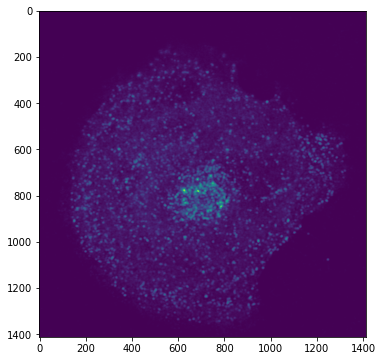

In [4]:
# plot "optimal" z slice of the 3D cell image
plt.figure(figsize=(6,6))
plt.imshow(zxy_arr[optimal_z])
plt.show()

## Test background removal

In [6]:
check_plot = True
radius=7
temp_folder = "temp"

t0=time()
print("Remove background...")
signal_arr = remove_background3D(zxy_arr, img_name, radius, temp_folder, check_plot=True, save=True)
t1=time()
diff=t1-t0
print(f"Completed in {diff:.2f} seconds")
print("Done!")

Remove background...
No .npy file for signal array found, computing signal array...
Completed in 73.93 seconds
Done!


## Test cell mask

In [15]:
check_plot = True
temp_folder = "temp"

sigma = 40
sigma_for_finding_minima = 0
n = 1
distance_min_max = 0.1

t0=time()
print("Computing 3D cell mask...") 
mask3D = create_mask3D(zxy_arr, img_name, sigma=40, iter_dilation3D=10, iter_erosion3D=10, iter_erosion2D=5, sigma_for_finding_minima=0, n_min=1, distance_min_max=0.1, temp_folder="temp", check_plot=True, save=True)
t1=time()
diff=t1-t0
print(f"Completed in {diff:.2f} seconds")
print("Done!")

Computing 3D cell mask...
No .npy file for cell mask found, computing cell mask array...
Apply 3D postprocessing...
Create new plots to check after postprocessing...
Completed in 186.41 seconds
Done!


In [16]:
print(np.sum(mask3D))

17951777


In [17]:
import PyQt5
%matplotlib qt
plot_3D_array(mask3D, x_scale=3, y_scale=3, z_scale=15)

In [14]:
%matplotlib inline

## Test autocorrelation

In [ ]:
desired_int = 100000000 

img_real = scale_image(signal_arr, desired_int)
img_csr = scale_image(mask3D, desired_int)

print(np.sum(img_real))
print(np.sum(img_csr))

t0=time()
print("Computing 3D autocorrelation for real image...")
auto_corr_real = autocorrelation_3D(img_real, "real_"+img_name, temp_folder, save=True)
t1=time()
diff=t1-t0
print(f"Completed in {diff:.2f} seconds")

t0=time()
print("Computing 3D autocorrelation for CSR image...")
auto_corr_csr = autocorrelation_3D(img_csr, "csr_"+img_name, temp_folder, save=True)
t1=time()
diff=t1-t0
print(f"Completed in {diff:.2f} seconds")

print("Done!")

99999822.25820999
99999999.99999969
Computing 3D autocorrelation for real image...
No .npy file for autocorrelation array found, computing and saving autocorrelation array...


## Test K-function (to do)

In [ ]:
range_of_t = np.linspace(1, 1200*0.0353, 40)
width = 1

t0=time()
print("Computing 3D distance array...")
dist_array = distance_arr3D(arr, len_x=0.0353, len_y=0.0353, len_z=0.15, temp_folder=temp_folder, save=False)
t1=time()
diff=t1-t0
print(f"Completed in {diff:.2f} seconds")


diff_autocorr = auto_corr_real-auto_corr_csr


t0=time()
print("Computing K-function...")

K_values = []

for t in range_of_t:

    # arrays containing the spatial auto-correlation up to distance t (+width)
    auto_corr_t_inner = cut_ellipsoid(diff_autocorr, dist_array=dist_array, radius=t)
    auto_corr_t_outer = cut_ellipsoid(diff_autocorr, dist_array=dist_array, radius=t+width)

    # cut out circles with specified width and radius out of autocorrelation function and sum the values
    sum_ = np.sum(auto_corr_t_outer-auto_corr_t_inner)

    K = sum_ # currently, no normalization
    K_values.append(K)

t1=time()
diff=t1-t0
print(f"Completed in {diff:.2f} seconds")

#### Some tests with blurring the entire 3D array and plotting histogram of pixel intensities

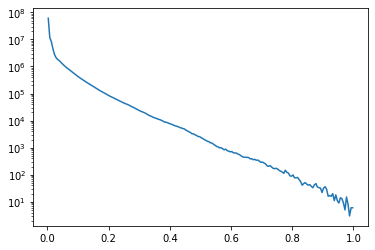

Done in 11.19 seconds!


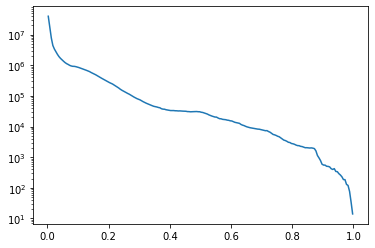

Done in 17.57 seconds!


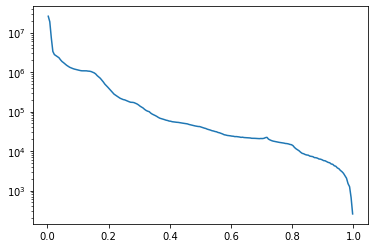

Done in 28.81 seconds!


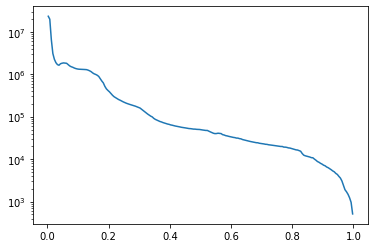

Done in 33.93 seconds!


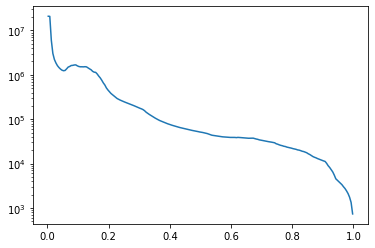

Done in 39.70 seconds!


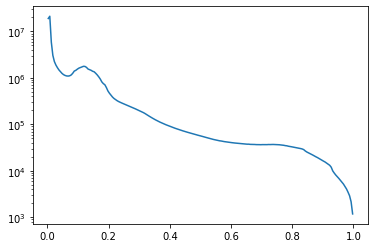

Done in 45.29 seconds!


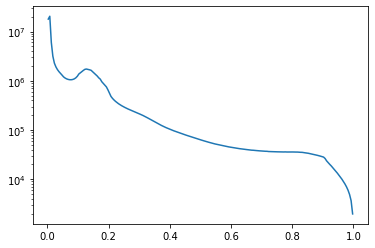

Done in 51.02 seconds!


In [25]:
img_array = signal_arr

import scipy.ndimage


for sigma in [5, 10, 20, 25, 30, 35, 40]:
    t0 = time()

    img_normalized = normalize_image(img_array)
    img_blur = img_normalized.copy()
    img_blur = scipy.ndimage.filters.gaussian_filter(img_blur, sigma=sigma)
    img_blur_norm = normalize_image(img_blur)

    # create histogram of blurred image intensities in order to find optimal cut-off
    # for extracting the cell shape from the image
    counts, bin_edges = np.histogram(img_blur_norm.ravel(), bins=200)
    bin_middles = np.diff(bin_edges)
    bin_middles = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    plt.plot(bin_middles, counts)
    plt.yscale('log')
    plt.show()

    t1 = time()
    print(f"Done in {t1-t0:.2f} seconds!")